In [1]:
%matplotlib inline
import string
from collections import defaultdict
import itertools
import numpy as np
import pandas as pd
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation

from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
# from spacy.en import English
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

from helper_functions import transform_tweet

/Users/maksym/virtualenvs/machine_learning/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def prepare_labels():
    emoji = pd.read_csv('emoji.txt', sep="\n", header=None)
    emoji.columns = ["icons"]
    emoji.index += 1
    return emoji

In [3]:
def transform_labels(emoji):
    for i, name in ((0, 'heart_eyes'), (1, 'yum'), (2, 'sob'), (3, 'blush'), (4, 'weary'),
                    (5, 'smirk'), (6, 'grin'), (7, 'flushed'), (8, 'relaxed'), (9, 'wink')):
        emoji['icons'].replace(name, i, inplace=True)
    emoji.reindex()
    return emoji

In [4]:
emoji = prepare_labels()
print(emoji.icons.unique())

['heart_eyes' 'yum' 'sob' 'blush' 'weary' 'smirk' 'grin' 'flushed'
 'relaxed' 'wink']


In [5]:
emoji = transform_labels(emoji)
print(emoji.icons.value_counts())

2    50525
0    39193
4    26855
3    22894
9    18078
1    16790
5    15231
6    15138
8    10472
7    10155
Name: icons, dtype: int64


In [6]:
emoji.values.flatten()

array([0, 1, 2, ..., 9, 2, 5])

In [7]:
# def prepare_features():
#     tweets = []
#     with open('tweets.txt') as f:
#         for line in f.readlines():
#             tweet = transform_tweet(line)
#             tweets.append(tweet)
#     return tweets

def prepare_features():
    tweets = []
    with open('tweets.txt') as f:
        for line in f.readlines():
            tweets.append(line)
    return tweets

In [8]:
tweets = prepare_features()
print(tweets[:2])

["RT @VibingOverHoes: Bet you'll get hungry  https://t.co/hOOU9xpmVq\n", 'Starbucks employee confuses boyfriend by saying is penis is tall \n']


In [9]:
# Dividing all data for train and test parts
inputs_train, inputs_test, \
expected_output_train, expected_output_test = train_test_split(tweets, emoji.values.flatten())  # matched OK

In [10]:
# Extracting features from text files
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(inputs_train)
X_train_counts.shape

(168998, 133253)

In [11]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(168998, 133253)

In [12]:
# Machine Learning
# Training Naive Bayes (NB) classifier on training data.
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, expected_output_train)

In [13]:
# Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
# The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
# We will be using the 'text_clf' going forward.
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

text_clf = text_clf.fit(inputs_train, expected_output_train)

In [14]:
# Performance of NB Classifier
import numpy as np
predicted = text_clf.predict(inputs_test)
np.mean(predicted == expected_output_test)

0.4363339428043953

In [15]:
# Training Support Vector Machines - SVM and calculating its performance

from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42))])

text_clf_svm = text_clf_svm.fit(inputs_train, expected_output_train)
predicted_svm = text_clf_svm.predict(inputs_test)
np.mean(predicted_svm == expected_output_test)

/Users/maksym/virtualenvs/machine_learning/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.43411499476328264

In [16]:
# Grid Search
# Here, we are creating a list of parameters for which we would like to do performance tuning. 
# All the parameters name start with the classifier name (remember the arbitrary name we gave). 
# E.g. vect__ngram_range; here we are telling to use unigram and bigrams and choose the one which is optimal.

from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1e-2, 1e-3)}

In [17]:
# Next, we create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(inputs_train, expected_output_train)

In [18]:
# To see the best mean score and the params, run the following code

gs_clf.best_score_
gs_clf.best_params_

# Output for above should be: The accuracy has now increased to ~90.6% for the NB classifier (not so naive anymore! 😄)
# and the corresponding parameters are {‘clf__alpha’: 0.01, ‘tfidf__use_idf’: True, ‘vect__ngram_range’: (1, 2)}.

{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}

In [19]:
# NLTK
# Removing stop words
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')), ('tfidf', TfidfTransformer()), 
                     ('clf', MultinomialNB())])

In [20]:
from nltk.stem.snowball import SnowballStemmer

class StemmedCountVectorizer(CountVectorizer):
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        def func(doc):
            for w in analyzer(doc):
                stemmed = self.stemmer.stem(w)
                yield stemmed

        return func

In [21]:
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')
text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect), 
                             ('tfidf', TfidfTransformer()), 
                             ('mnb', MultinomialNB(fit_prior=False))])

text_mnb_stemmed = text_mnb_stemmed.fit(inputs_train, expected_output_train)

predicted_mnb_stemmed = text_mnb_stemmed.predict(inputs_test)

np.mean(predicted_mnb_stemmed == expected_output_test)

# now we can save it to a file
joblib.dump(text_mnb_stemmed, 'model.pkl')

print("Accuracy:", accuracy_score(expected_output_test, predicted_mnb_stemmed))

Accuracy: 0.489659702128


In [22]:
for (sample, pred) in zip(inputs_test, predicted_mnb_stemmed):
    print(sample, ">>>>>", pred)

When ur hungover and your boyfriend says "do u want Starbucks or McNuggets" ... 
 >>>>> 2
RT @HarryNiall_Pics: Can you imagine if Niall ever gave us a goodnight snapchat video  haha I bet it would be something like "goodnight al…
 >>>>> 3
On this Alabama kush I'm so high on bet 
 >>>>> 8
Starbucks has almond milk now
 >>>>> 0
That subway hit the spot. 
 >>>>> 1
RT @bitchhellnaw: Since McDonalds fired me the secret to the Mac sauce is mayonnaise mustard and ketchup 
 >>>>> 3
@Sassy_Nicola   I bet Jaxon will be liking me running about in them. 
 >>>>> 2
RT @TheyDreadJoJo: Fooling In Walmart With @MalOsoArroagant  #RunningManChallenge https://t.co/MY8pqLTzku
 >>>>> 2
@ThatAmbrose2299  does that say Starbucks?
 >>>>> 2
@Phily_flores and I bet you Ima be starving in 30/40 mins 
 >>>>> 2
RT @BTSJimin_PH: im looking for the girl who sat w/ me&amp; @parkjammin95 at starbucks yesterday aftr concert. u forgot ur wallet PLS RT https…
 >>>>> 2
I Got My Shot I Bet I Wont Miss
 >>>>> 2
RT @Tamaraala

 >>>>> 1
I crave Starbucks 24-7 
 >>>>> 4
Subway and Panera Bread have the best cookies 
 >>>>> 4
Everybody go to the VMA's and say fuck the BET Awards
 >>>>> 2
I really need some soup and subway don't have any 
 >>>>> 4
Iced caramel machiatto is my new favorite Starbucks drink
 >>>>> 0
RT @janvee_gooo: Nothing makes me happier than Starbucks 
 >>>>> 1
RT @PuppuccinoHQ: You can never be too happy when it comes to Starbucks and puppies  https://t.co/UPZ6SJZD8r
 >>>>> 0
@Starbucks is getting almond milk 
 >>>>> 0
RT @Greenetatum: Most girls are addicted to Starbucks but I'm addicted to Jamba 
 >>>>> 0
FREE $10 Starbucks Gift Card for everyone who enters!!  https://t.co/NxYnNESNyg https://t.co/HqqMAmygzL
 >>>>> 0
My baby looks so pretty with her windows tinted..police bet not say shit to me
 >>>>> 2
RT @iamYungMak: @AyePeeDub yes  never had the potato lol I bet it's good too.
 >>>>> 1
STARBUCKS FORGOT TO PUT MY SHOT OF EXPRESSO IN MY CHAI AND NOW ALL I HAVE IS A VENTI MILK 
 >>>>> 2
@_Bry

 >>>>> 0
Money ain't everything but I bet you need it more than you don't 
 >>>>> 2
@madmunk @Duckingbarstool Mmm i bet it leaves your socket Daisy fresh 
 >>>>> 1
RT @vane_gallardo13: Latte at @DunkinDonuts $1.99 from 12-6  not happy hr but I do like my latte
 >>>>> 0
@LasheSalu the day I bought you subway 
 >>>>> 2
RT @alexis_miara: She's happy  After a long day at gym she deserved a Starbucks! #LiveLikeMolly Hope you like your drink @Honey_B15! https…
 >>>>> 3
RT @DOMLEAFY: Nobody showed up 2 work at McDonalds today  https://t.co/4g0Pobbpht
 >>>>> 2
I bet they're going to watch suicide squad  @GraysonDolan @EthanDolan https://t.co/DO5lrQph7H
 >>>>> 0
Ay bet! Di ako maka palda, but I think with this I might  #ALDUBLoveCutsTime https://t.co/Gy17uq15y6
 >>>>> 0
RT @AthVinesOnly: Bet you've never seen a ball hit off the TOP of a foul pole before  https://t.co/IdNCrNoBUo
 >>>>> 7
She On FT , Holdin up The Line At McDonalds 
 >>>>> 2
Okay so I'm buying more gazelles with my free bet money

 >>>>> 0
RT @Adisa_Hasanovic: I bet my mum and dad hate me after how much they've spent on me this month
 >>>>> 2
Lex from Burgerking️ have it your way  https://t.co/625XWbx5va
 >>>>> 2
RT @vin_deisel: Bet y'all won't retweet  http://t.co/OXZ0siSS79
 >>>>> 6
bet he got plenty of females tryna get at him. 
 >>>>> 2
RT @callmeDIRA__: goin bet the black ones this fall  https://t.co/Em4d8eG8Zg
 >>>>> 2
Wanna go to Starbucks?   #WinMeOverIn4Words
 >>>>> 0
RT @prettyhurts801: "The door is on your left."   I'm suddenly in love  https://t.co/PczSLK4xK9
 >>>>> 0
Ight bet
 >>>>> 3
@CharlieKingTips easy 30 quid after the weekends results/performances? Barça 3/1 at wkend was a good bet, but look what happened there 
 >>>>> 2
I want some Wingstop or Subway
 >>>>> 2
@taaay_24 I bet!! I can't wait for pumpkin candles to come in at work.  and I want too! But at work now 
 >>>>> 0
craving subway 
 >>>>> 4
Bruh subway really trying to kill me 
 >>>>> 2
don't know if I wanna cook breakfast or just go to 

 >>>>> 0
RT @jorgebaseball5: I bet you didn't know I had a twin sister!! ️️ https://t.co/tPxFqB6Dot
 >>>>> 8
Meanwhile I found out they don't sell my Ben &amp; Jerry's ice cream at Walmart anymore and I'm distraught 
 >>>>> 2
Thank god for this  #starbucks https://t.co/VnEskpwfEY
 >>>>> 2
&amp; mcdonalds  &amp; went &amp; got it
 >>>>> 2
RT @JakobOwens: I think @Walmart should send me a check in the mail! 
 >>>>> 2
@12O7PM @_knaty @Diegoo_Lander bet &amp; I was home crying Juan Gabriel death 
 >>>>> 2
RT @damndessa: When you're the first person to order the pumpkin spice latte at Starbucks  https://t.co/Mlhqgenwt5
 >>>>> 0
the dollar stores  https://t.co/GwafAhkUWD
 >>>>> 2
Mobile ordered a Butterbeer Latte from Starbucks  Great way to start the day!
 >>>>> 0
I bet I won't be up here or anywhere after 8 lol, Bro just go to bed  https://t.co/uPVXrt62it
 >>>>> 2
crying bc tomorrow is the last day of Dunkin happy hour   @DunkinDonuts pls fix this
 >>>>> 2
You can hear her say "This is why

 >>>>> 8
RT @MyJaps: Thank you. :)?RT @amiracel5: @MyJaps just wanna now what songs are in ur playlist right now? Bet it was great songs  
 >>>>> 3
THIS HAPPENS TO ME ALL THE TIME  IT PMO LIKE JUST CUS IM SALVADORIAN DNT MEAN IM IN MS13  https://t.co/NAkSw91Giv
 >>>>> 2
@Sam___Hurley I bet....good for u 
 >>>>> 0
RT @BobbyJOnline: There's no need. Ya'll already have ABC, NBC, FOX, CW, HSN, TBS, WGN, QVC, MTV, TNT, VH1 to name a few  https://t.co/mZO…
 >>>>> 3
Not really the type to let a nigga talk backwards but Ima let it slide because my niggas to violent!!!  #bet
 >>>>> 2
RT @DevinDavinci:  RT @LifeAsKing: “bet you never had some pussy talk back to you“ RT @DreamGirlsOnly: Quote this https://t.co/x6pWC477aC
 >>>>> 2
Oh boy  https://t.co/z700DVewmK
 >>>>> 0
THIS  https://t.co/PTeyIuiCjT
 >>>>> 0
@dominos ur website was down, couldn't order! Been a stressful experience after a few beers!!! 
 >>>>> 2
RT @lunndyy: Bet the kids in high school that threw muffins at me after lunch never th

 >>>>> 1
@GBetochacon Yum. I bet that's delicious. I love @Oreos and I love cheesecake. 
 >>>>> 1
RT @bugsmila: I bet Camila was crying backstage while hearing this  it sounds so beautiful. https://t.co/KVZjT71mAq
 >>>>> 2
RT @ConnorFranta: special thanks to @starbucks for sending me this little care package! I love it  http://t.co/W9RpLcbv8n
 >>>>> 3
RT @Karenolivo: I bet you can do better than that... https://t.co/zpvjaps4xn
 >>>>> 5
Amazing @annaturley!  So great to have your continued support https://t.co/Ioerseva2w
 >>>>> 3
When @Starbucks doesn't fill your drink to the top  #bummed#mymorningjoe https://t.co/if3krzYLVg
 >>>>> 2
No moves this weekend but I bet next weekend when the kids home, everybody gonna wanna go out 
 >>>>> 2
This girl for real all this for free pizza from dominos  https://t.co/3eSRG27u0g
 >>>>> 0
@ayiecorto ow may lowrd!  @Starbucks
 >>>>> 4
RT @StateSnapsOG: Walmart blunt  #DoItForState #StateSnaps https://t.co/oCsN4jRq3c
 >>>>> 6
I went to load $10 on my St

 >>>>> 4
RT @TRichbaseball15: @dominos you are the real MVP https://t.co/Npl05HVHFM
 >>>>> 0
Kendall with Pizza Boys. I bet Lauren is there with them  https://t.co/qfetNPFBHH
 >>>>> 0
If only Starbucks delivered 
 >>>>> 4
Nothing better than a dominos but always regret eating it right after I finish it 
 >>>>> 2
@_gkhjr I'm at taco Tuesday  and I bet y'all at they house, far af
 >>>>> 4
RT @Mijaaaaaaaaa: Merdeka promo, lets?  1. Baskin Robbins 17-19 August  2. Subway 22 August  3. Secret Recipe 31 August https://t.co/2j7Zp…
 >>>>> 0
RT @KameronBennett: I ran into one of My old teachers at Starbucks he asked how I was doing... I said Sensational  https://t.co/Apua4SFOYx
 >>>>> 2
RT @Maichardology: *CRIES IN LATIN* If they weren't on cam, I BET SHE WOULD KISS HIM UNDERWATER KILL ME NAO #ALDUBAdvocatesOfLove  https:…
 >>>>> 4
RT @FunnyVideoGame: THIS DUDE IS AT MCDONALDS PLAYING HIS PC https://t.co/vxWBY31neb
 >>>>> 2
@_TheRealSqwill  bet she said nothing but good things
 >>>>> 2
RT @JoeK

 >>>>> 2
Bet no one you've been w even know you're a freak .. You only do that shit w me 
 >>>>> 2
Bet ko si Francis for this round!  #ALDUBLPUltimateBattle #MAICHARDImYours
 >>>>> 3
@Charlottegshore bet you do..you mean Brad's eggs?..
 >>>>> 9
RT @noriegee: Walmart  @mainedcm   #ALDUBDateKay https://t.co/Cg3Lw61dwy
 >>>>> 0
Someone bring me Starbucks please 
 >>>>> 4
@_JohnW  I bet!
 >>>>> 9
just heard a freshman refer to a metro card as her "subway ticket" 
 >>>>> 6
didnt even get to go to starbucks againoops
 >>>>> 2
Get voting mate @shaaan_houghton  https://t.co/LEGkxGLz7C
 >>>>> 9
@mxtsuokas you bet girl!! Obrigada Braga 
 >>>>> 3
Subway  https://t.co/xxk8iWSXRU
 >>>>> 1
In desperate need of a dominos, havent had one in ages 
 >>>>> 4
I have had Chick-fil-A and a smoothie from Starbucks 
 >>>>> 4
@Lightskin__X bet cuz u barely come anymore lmao 
 >>>>> 2
My mom brought me home makeup last night and Starbucks for breakfast  https://t.co/YfzROP9gE2
 >>>>> 0
@cmc_bossman I Bet It Is 

 >>>>> 2
RT @JamieBall5J: @Starbucks absolutely destroyed blocks from my hotel @CourtyardHotels in Kokomo, IN!  https://t.co/QevPLSPuA5
 >>>>> 7
If someone took me a starbucks caramel frappé in the morning my birthday would be amazing 
 >>>>> 0
RT @KGullic: @atapungot @twhiddleston oh my gosh! I bet the kids loved that moment! Thank you for sharing! 
 >>>>> 8
RT @almightycurve: @OzzySmith333 @ErikStinson45 I bet Erik calls Judy squirtle 
 >>>>> 3
Lol not funny at all  https://t.co/5NHSvoxN7U
 >>>>> 2
RT @TheVampsJames: Being veggie, I doubt it  @SammyAlbon @dominos
 >>>>> 9
RT @Nic0leLa: McDonalds
 >>>>> 2
Don't get me wrong I love Jesus but this church school stuff is the most I bet I'm bout to get hella hours cut 
 >>>>> 2
I bet you The Sonic Boom of the South can do it better The Best Band in the Land.  https://t.co/0UwwrxJmuG
 >>>>> 2
Sage brought me starbucks 
 >>>>> 0
RT @manithedoll: that's a bet  https://t.co/R85p0JDM13
 >>>>> 0
RT @_MeganLambert: I can't wait until I can drive

 >>>>> 2
@MonkeyPicks @FusionOnAir I bet 
 >>>>> 9
I bet it was 
 >>>>> 9
RT @Chef_Shellaaay: Say what y'all want about the BET awards, but they inspired this award show  #VMAs
 >>>>> 2
the subway in brown is sooooo slow. 
 >>>>> 2
RT @iDoll_Quasiaa: I bet yall won't @ yall ex' this video  .. . http://t.co/A5PSdBC2EV
 >>>>> 2
Kudos Jermaine!  Thank your mom for raising a good son/person!! https://t.co/e3ClZene2V
 >>>>> 0
RT @MoneyyRobbie_s: @Srrvxviii I couldn't even look @ first, I'm like he bet not do that to that boy 
 >>>>> 2
RT @IISuperwomanII: YOU KNOW ME SO WELL  https://t.co/qDPK9JARz5
 >>>>> 2
RT @ColleenB123: Miss him sooooo much.  https://t.co/ELgsG3ltW4
 >>>>> 2
RT @ItsFoodPorn: Starbucks summer drinks   https://t.co/RlMXEG31yW
 >>>>> 0
RT @kuhnu2012: @HillaryClinton @Toure Witch Please..go tell that Crap to @ABCWorldNews @CNN @MSNBC @BarackObama @OWNTV @MTV @BET  https:/…
 >>>>> 5
@dblanque I bet there is a red haired bitch in there too 
 >>>>> 2
. That's why your mans sle

 >>>>> 4
Happy ask because I got Starbucks 
 >>>>> 0
I Bet You Never Had A Girl Do It Like Me 
 >>>>> 2
RT @TourBTS: Anie from Starbucks https://t.co/6z2qBEEz9S
 >>>>> 0
@walter_sentsho I bet they started using ratex more often 
 >>>>> 2
Lmao I was finna tweet u "I bet you nutted "  https://t.co/WFRmXkAyly
 >>>>> 2
RT @g0dsentme4u: I just wanna dig @TiggerReddXXX just like this, I bet his ass is out of this universe.  https://t.co/GXZ35H4Qjt
 >>>>> 0
RT @LuluOnCam: No pencilskirt outfit is complete without Starbucks! Thanks for the drink and the skirt @add_tendency  https://t.co/2P4hsc…
 >>>>> 0
@67Kelechi that goal meant I didn't win my bet
 >>>>> 2
RT @TheVampsJames: Being veggie, I doubt it  @SammyAlbon @dominos
 >>>>> 9
@bigbangwho he has grown up to be a fine and strong man  i bet your damn @$$ he is shady
 >>>>> 2
Off and at subway 
 >>>>> 1
Good Morning, happy weekend  #bfast #morning #starbucks #nathos #sarapan #laper @ Starbucks… https://t.co/SzSm3ZVEZG
 >>>>> 3
So sad @Starbu

 >>>>> 4
she's coming back to end her work and end those bitches + ali  https://t.co/A1EwaZMBH1
 >>>>> 2
Omw To Get Some Rn.  https://t.co/VXLD3v0ela
 >>>>> 4
@MaddySwag666 I bet lol. Congrats on getting to be over in the makeup area at Von Maur your makeup always looks flawless! &amp; thanks girl!
 >>>>> 3
RT @KathleenLights1: Is there a way I can order a PSL without any dairy at all?!? @Starbucks unfortunately it's made with condensed milk. …
 >>>>> 2
RT @BET_Africa: The truth in this trailer gives us the chills  Catch Interwoven this Sat 24 Sep @ 20:00 CAT on BET Channel 129 https://t.c…
 >>>>> 6
RT @daddy_yankee: @loveradiomanila difficult to choose my favorite!  #shakyshakychallege #Philippines  https://t.co/Z3B3MPrQTP
 >>>>> 6
you ain't gotta like me, bet you know my name though 
 >>>>> 5
Starbucks
 >>>>> 0
I want Starbucks! 
 >>>>> 4
Starbucks   https://t.co/uXJf4JywUV
 >>>>> 0
RT @MaggieCarson__: ask your boyfriend about me I bet you he knows 
 >>>>> 2
RT @VibingOverHoes: Bet y

 >>>>> 4
Subway cookies are the best 
 >>>>> 0
@chantelllll I bet! I'm very happy for you 
 >>>>> 0
RT @FunnyVideoGame: THIS DUDE IS AT MCDONALDS PLAYING HIS PC https://t.co/vxWBY31neb
 >>>>> 2
@bizdawes @JonAntoine Wonderful collection I have one similar at my house lol I bet many @TheFantoines have too we are blessed yo know him 
 >>>>> 3
RT @httpisaac_: A cutie just stopped me at Walmart and she said she was supporting me for 2 years ... She was soooo cute and adorbs...
 >>>>> 2
RT @noriegee: Ay bet  #ALDUBSelflessActs https://t.co/gXSgDSMl7b
 >>>>> 1
Mcdonalds 
 >>>>> 2
RT @ultyerim: but i don't  https://t.co/fBe3BwEGGd
 >>>>> 1
U bet RT @NEWMONEY02: @HarlemHunnieBun that was my fav drink back n the day lol i use to b so fried 
 >>>>> 0
When you go to @McDonalds to get a Big Mac but come to find out the one in Redding doesn't serve lunch until 12:30 
 >>>>> 2
@MyleneTerrones the one from Starbucks is the best! 
 >>>>> 2
They were playing  @Beyonce 's Sorry in Walmart today 
 >>>>> 

@_kaylizzzle have you had the salted caramel stuff from Starbucks yet? It's so good 
 >>>>> 0
RT @waynelineker: Boys..if you don't remember her name in the morning..little trick..take her to Starbucks 
 >>>>> 9
RT @TheW1seONE: When the person in front of me in the Starbucks line paid for my order!! #PayItForward  https://t.co/yK1UZotqxa
 >>>>> 0
&amp; I bet she thinks I'm going to unblock her too https://t.co/hmrqlVF0gi
 >>>>> 2
And I bet half those dudes have girlfriends!!! Insane lol 
 >>>>> 2
RT @Mijaaaaaaaaa: Merdeka promo, lets?  1. Baskin Robbins 17-19 August  2. Subway 22 August  3. Secret Recipe 31 August https://t.co/2j7Zp…
 >>>>> 0
Bet @MattTerry93's ex girlfriend is regretting breaking his heart now #herloss 
 >>>>> 2
My @DunkinDonuts free drink code didn't work and now I don't know what to do with my day 
 >>>>> 2
RT @JJoceeelyn: I want Starbucks 
 >>>>> 2
RT @wtvrkatelyn: He'll let you buy him a meal but won't let you get a pic with him tragic  https://t.co/92vgvALG8S
 >>>

 >>>>> 2
lmao I keep making eye contact with a girl all the way directly across the mcdonalds and I feel so uncomfortable 
 >>>>> 2
@MichaelCsBoobs you making me smile  bet you'd do that to Michael too
 >>>>> 4
RT @__Mdu: Your clubs have UCL football but I bet they don't make you smile like mine just made me smile  #FirstNeverFollows
 >>>>> 3
@HilMarHustler bet you know that song by Dru Hill called "Real Freak" sing that song️
 >>>>> 2
RT @josetunonmusic: NorthStar headed there rn ️ miss is to much, I need Starbucks wifi  cause it's faster than my house wifi 
 >>>>> 2
RT @beebopdoopwhoop: Bet you I could make Jacob Price nut in less than 30 seconds  https://t.co/J3gUF9KTEo
 >>>>> 0
I honestly feel so special that I have a GOLD starbucks card now️ https://t.co/WjWAEaLGMa
 >>>>> 0
The only subway I can eat here is Tuna  sometimes Canada sucks. I miss uk everytime I walk into Subway 
 >>>>> 2
I ain't make the deans list but I bet I'll make the Forbes list.#russ MOOOOOD
 >>>>> 5
New favori

 >>>>> 2
@yazmincruz141 damn, I bet you scored the winning touch down huh? 
 >>>>> 2
RT @veruca_crews: .@Haylijahlover I bet, and I put anything on the #Lucky7, that they'll surprise us every frickin Thursday.. As usual.. …
 >>>>> 6
RT @nogoodcharles: I bet she got that snapback and I don't mean hats 
 >>>>> 0
Ima see y'all tomorrow  https://t.co/PDqqzZHK6X
 >>>>> 2
@Starbucks yummy!! 
 >>>>> 1
Subway hit the spot. ️
 >>>>> 1
1 game off winning £150 from a free bet hehehe
 >>>>> 3
The fact that Bethan said she'll leave earlier so I can get a Starbucks before college makes me a very happy bean
 >>>>> 2
Bet 365 are verifying my account so can put any bets on 
 >>>>> 6
I went to Starbucks this morning and ordered my PSL and when I went up to the window the girl said "we covered it happy Labor Day Connor" 
 >>>>> 2
RT @Mijaaaaaaaaa: Merdeka promo, lets?  1. Baskin Robbins 17-19 August  2. Subway 22 August  3. Secret Recipe 31 August https://t.co/2j7Zp…
 >>>>> 0
Aw, the lady at Starbucks sa

 >>>>> 2
Cesar surprised me with roses &amp; Starbucks 
 >>>>> 0
Doing the Fan Duel thing this season so let's see how far this $10 gets me. (I already want to bet it all today )
 >>>>> 0
RT @Katie__Pollock: mcdonalds has the best sweet tea 
 >>>>> 0
 making me a trip to Starbucks https://t.co/qciV4IiUy3
 >>>>> 3
I bet bow wow is lookin at Twitter right now like 
 >>>>> 2
RT @DeejayCombs: I try to be ️ and I love you too!  https://t.co/5bv56LTYxn
 >>>>> 8
@Kdazzle_98 @emma_herzig you bet your bottom dollar we did
 >>>>> 2
Now there's a cutie at starbucks what did I do to deserve this 
 >>>>> 2
I just bought my self a subway sandwich for lunch and hk I want to eat it rn 
 >>>>> 4
SCRATCH THAT dominos and the GAME  almost forgot ️ and now back to that bae thing  #tmlt
 >>>>> 2
Woah  https://t.co/WjNFMtCyOD
 >>>>> 7
@ChinaaMarinaa they're cheaper at Walmart I think. You're welcome! 
 >>>>> 3
@deancore Ha! I bet you never thought you'd fit that clip seemlessly into a conversation. 
 >>>>> 

 >>>>> 2
RT @VibingOverHoes: Bet you'll get hungry  https://t.co/hOOU9xpmVq
 >>>>> 0
How much they cost  https://t.co/vAZ3gCABMH
 >>>>> 2
i was slumped but popped up as soon as i heard my mom outside wit some mcdonalds 
 >>>>> 2
Bet she do a lot more too  https://t.co/j2MiksnCX5
 >>>>> 2
Getting McDonalds breakfast on my birthday will never get old 
 >>>>> 0
I haven't had starbucks in so long  im so upset
 >>>>> 2
We'll forgive you.  https://t.co/LQs5U5Hffj
 >>>>> 3
Craving subway 
 >>>>> 4
I wish lunch would come quicker I need Starbucks and food 
 >>>>> 4
I bet there are some people out there puking right now cause they partied too hard... Meanwhile I just ate shitty 
 >>>>> 2
RT @urgirlsfave: @meciaaaa_ I bet you look amazing. 
 >>>>> 0
@UniqueMist2 @ManCity @Everton I bet you play in goal too....I think you're a keeper 
 >>>>> 4
Starbucks has all there fall drinks omg️ @laurenhill928 https://t.co/fdIEmi0pm0
 >>>>> 0
RT @sabs0ul: who wants to go on a starbucks date with me? https://

 >>>>> 2
RT @PuppuccinoHQ: You can never be too happy when it comes to Starbucks and puppies  https://t.co/UPZ6SJZD8r
 >>>>> 0
I turned in my 125 stars today for a Starbucks star reward and now I'm rewarding myself with a Trenta cold brew coffee... 
 >>>>> 0
 (at @Subway in Duarte, CA) https://t.co/x5atp3iNeO
 >>>>> 1
RT @TheVampsJames: Being veggie, I doubt it  @SammyAlbon @dominos
 >>>>> 9
I want pf &amp; wing stop &amp; starbucks
 >>>>> 2
Smoking before coming to this Chinese Buffet was definitely a bet 
 >>>>> 0
Dat man look gone bet he dont recall takin that pic  https://t.co/wqdTPzU4PP
 >>>>> 2
Back in the realm of #Starbucks  https://t.co/CW08PRMfQa
 >>>>> 1
I want subway
 >>>>> 4
Oh my god  https://t.co/8ag1q9fN8s
 >>>>> 2
RT @_maaryyjanee_: I bet this taste wonderful  https://t.co/dxFKlnCBgT
 >>>>> 2
@rikerR5 I bet you'd like to be having a caipirinha 
 >>>>> 9
@LakeciaLampkinH ! I bet.. How's the grandbabies? My condolences for your loss, how's Risha?!
 >>>>> 2
RT @ofcnewscas

 >>>>> 9
Probably hitting up the explicit section of Robron fanfic's ️ I bet he's reading @FunGh0ulz smut  https://t.co/yH0yqBwkdb
 >>>>> 5
@guapo_chief aight bet 
 >>>>> 2
@vtothepowerof2 My first class of the day is right next to our starbucks, so tempting everyday 
 >>>>> 2
@YourPunMaster //I bet you fifty bucks that they're loving you already! 
 >>>>> 2
RT @lauramarano: @trouxaformarano I want tooooooo! I bet it's so crazy right now because of the olympics 
 >>>>> 0
Bet Payet couldn't even do that . #Coutinho #LFC
 >>>>> 9
RT @niallsbunny16: And.... Here we go again! I bet you we get babygate pics!! Tomorrow is fuckin Tuesday!!  https://t.co/uuQS25rhC8
 >>>>> 3
I want mcdonalds but I can't hold it down right now 
 >>>>> 2
@PoulanBrooke bet when and where
 >>>>> 9
i wish @Starbucks delivered 
 >>>>> 4
@lynmayoral I bet but I hella get you lol but it's ok maybe te cresen nalgas
 >>>>> 3
@alizenichtryon bet I'm at school tho
 >>>>> 8
RT @Mijaaaaaaaaa: Merdeka promo, lets?  1. Baskin R

 >>>>> 2
shout out to the starbucks barista who gave me a trenta when i only ordered a tall 
 >>>>> 0
@_SaltedEarth awwww hehe I bet yours is a cutie also! 
 >>>>> 0
U can bet dat never gotta sweat dat ️️
 >>>>> 5
nooo recien me doy cuebta que cerraron Subway 
 >>>>> 2
RT @_theycallmetrey: I told this lesbian that I bet my dick could turn her straight  she still a lesbian but I still got to fuck so we eve…
 >>>>> 5
McDonald money  https://t.co/NG5s0Il7oI
 >>>>> 2
The Carmel waffle cone frappuchino at Starbucks is the best 
 >>>>> 0
@Cowboys_Jlw5 I bet Grigson would be the guy that'd give the most for Ron right now, along w/ Loomis in NO. Bidding war? 
 >>>>> 2
wish someone could bring me Starbucks 
 >>>>> 4
I really want starbucks
 >>>>> 4
RT @CforCarolina: we're taking margarita and Melissa to McDonalds for their birthdays @_sharondenisse 
 >>>>> 3
RT @RedBoneKkay: Ugly MFS: You got some sexy ass lips. I bet they soft  Me: https://t.co/dFgLNpBMVK
 >>>>> 5
RT @miriam_denisse_: I want S

 >>>>> 4
RT @dira_marie: Hungry as shit rn I JUST WANT A TEA FROM STARBUCKS 
 >>>>> 4
bought joe subway and @GracieDelventh1 goes "you're such a good ex gf" 
 >>>>> 2
Someone buy me a @Starbucks Pumpkin Spice Frappe 
 >>>>> 0
RT @TillerDaily: When Tiller goes to Subway  https://t.co/tvyW890KdT
 >>>>> 2
RT @bugsmila: Starbucks is playing "All of me" and I'm trying my best to not cry. God I love this song so much 
 >>>>> 2
I bet I never call again 
 >>>>> 9
my phone died at starbucks and some man gave me his charger plus the car adapter to use and told me i could give it to him next week
 >>>>> 2
I Have A Starbucks Addiction 
 >>>>> 4
@BreGrau I was over yesterday in Starbucks and was like how is this even serious so thankful I'm only in the business building from now on
 >>>>> 2
@nick_mitch17 K. bet 
 >>>>> 9
@JohnKasich @MeetThePress @chucktodd I wouldn't watch Kasich on a bet.
 >>>>> 3
payday I'm treating myself to Starbucks. ️
 >>>>> 0
Rakia came in clutch with subway 
 >>>>> 1
RT @s

 >>>>> 1
I wish I had Sheetz near me for a strawberry smoothie with whipped cream. https://t.co/k1t69DNsLf
 >>>>> 4
RT @bugsmila: I bet Camila was crying backstage while hearing this  it sounds so beautiful. https://t.co/KVZjT71mAq
 >>>>> 2
RT @NewDistrict: Subway https://t.co/qxMis7spao
 >>>>> 0
RT @december_melody: Look what i saw just now!! BTOB @OFFICIALBTOB @TBJnearby subway ad   @PenielShin @btob2mh https://t.co/gxrt9ngzPV
 >>>>> 0
I love subway 
 >>>>> 0
@spockandroll omg what why extra burgers I don't understand hahah omg dont because I always get a chocolate milkshake I bet it's amazing
 >>>>> 0
RT @VibingOverHoes: Bet you'll get hungry  https://t.co/hOOU9xpmVq
 >>>>> 0
@RedneckKacie I bet you would too  lol #coolkids
 >>>>> 3
RT @AlDubnations: LOLA'S PLAYLIST ULTIMATE BATTLE NA! HAPPY WATCHING! SINO BET NYO?   #ALDUBLPUltimateBattle
 >>>>> 3
@LivingSexy247 We'll take that bet. 
 >>>>> 0
RT @AthleticDesires: What are they putting in Starbucks these days  https://t.co/6b5ETqO0T

 >>>>> 2
@DAV0_BAZ good luck David, I bet you'll do fab ️
 >>>>> 3
@kaybtoo @bigdoh @SummerPic @JEM1979 @SamHeughan Yes, me too! In the book she calls him just short of being homely. LOL! Bet he won't be! 
 >>>>> 3
RT @TheyDreadJoJo: Fooling In Walmart With @MalOsoArroagant  #RunningManChallenge https://t.co/MY8pqLTzku
 >>>>> 2
@kevindelph I. bet you he will 
 >>>>> 9
craving Starbucks 
 >>>>> 4
Bringing my leftover dominos pizza to work was a good idea 
 >>>>> 0
@GraysonDolan I bet it's going to be great! 
 >>>>> 3
can they just bring all of them back on the show  https://t.co/WBMYpDPvTG
 >>>>> 4
Nobody will bring me subway 
 >>>>> 4
I want some churros from sheetz with caramel sauce 
 >>>>> 0
@MaxC25 I bet man  went up there last season and they score a last second equaliser and it was fucking shite man, must've been mental
 >>>>> 2
Bet @Amanda1010XL wishes had a nickel for every time a guy used that 'gorgeous' line on her 
 >>>>> 4
 This white woman really left her child alone for t

 >>>>> 2
@kirstensneath1 I bet! Lol! 
 >>>>> 3
my car smells like mcdonalds, cookies, and mud 
 >>>>> 2
@TerhijaesMommy bet his lil ass wont touch it nomore
 >>>>> 2
RT @cassieeswann: a guy at starbucks just paid for the rest of my food and drink because I didn't have enough money, i'm literally crying …
 >>>>> 2
RT @x___haleighh: I hope to god oomf EVER comes for me  BET
 >>>>> 2
Hunting pokemon w starbucks da best @ Setia Walk Puchong https://t.co/xQ2FOp8Eus
 >>>>> 0
@HaszSoDifferent I bet you do 
 >>>>> 9
RT @TheVampsJames: Being veggie, I doubt it  @SammyAlbon @dominos
 >>>>> 9
RT @chlxe_: expectations vs reality @McDonalds  https://t.co/oBa7Eh5jJ3
 >>>>> 2
@BoyGeorge80s @amywrayy  well I thought the way Amy tweeted it was very funny and dont worry I bet george Finds it funny to 
 >>>>> 2
RT @noriegee: Pak! Bet na bet girl @mainedcm   #ALDUBLastCondition https://t.co/NBfSOMbFU7
 >>>>> 5
RT @SqueezeBox_: @alex_whipkey "dominos and 7 up and Seagrams"..... Or wine 
 >>>>> 9
The smell 

 >>>>> 0
Why are we about to be w some Muncie locals tn  this gunna be ppl of Walmart: house party edition
 >>>>> 2
RT @Nav_Bernal: Walmart  Antioch, CA https://t.co/2nx7qlb49i
 >>>>> 0
@MynameAldo_o I actually love a challenge lol if you were to bet me. It would be more likely I'd do it 
 >>>>> 0
I want starbucks
 >>>>> 4
@houstonscrew you lost your bet too. But Damaya you should see her  almost made me change my life
 >>>>> 2
@mingyusmercier if i see him on your story you bet ill call your mum to let her know first 
 >>>>> 2
RT @Dashaxxx2: It done went from four season getting shot up , to Lakewood now blvd &amp; i bet whatever beef it is it ain't bout NOTHING 
 >>>>> 4
I bet on cm punk so he better win 
 >>>>> 3
Only for One Night is really pushing my buttons.  @BET
 >>>>> 0
See 'Pates'playing tonight on TV I bet he is pissing himself at DUFC like Gunning on Tues &amp; Rankin on Sat have been #noPatonNoPromotion
 >>>>> 2
RT @DrewskiJ_: Can @Starbucks just release their holiday flavo

 >>>>> 2
RT @BulletsEdge: The conventional bathroom celfié @ Starbucks Session Road, Baguio City  https://t.co/tK57fvnElP
 >>>>> 5
@DaveJonty1982 the bet is on £1 English pound 
 >>>>> 2
I want subway 
 >>>>> 4
@paigeshardlow_ bet I'm missing your best smile of the year  xx
 >>>>> 3
Can't twerk but I bet you I can make some bomb ass food fo ya 
 >>>>> 2
I bet that shit good asf https://t.co/gMipybvbFs
 >>>>> 2
subway sugar cookies are my favorite 
 >>>>> 1
@Neillygrownup I bet you are 
 >>>>> 9
RT @TheVampsJames: Being veggie, I doubt it  @SammyAlbon @dominos
 >>>>> 9
Im in love with chicken nuggets from mcdonalds and wendys long as they fresh 
 >>>>> 2
craving Starbucks
 >>>>> 4
@_xMiyaaa I bet he don't be talkin bout you this much . 
 >>>>> 2
lisette just showed up at my house with Starbucks and balloons 
 >>>>> 2
RT @ThisisLully: I bet the pink bunny is for her little girl  https://t.co/PNGgdAZ9EM
 >>>>> 0
@BitchassChicken I bet ever thing else is fat too right? 
 >>>>> 2
Wow! Love 

 >>>>> 4
So after not eating for 11 days... I am proud to announce im pregnant with a dominos food baby and I've never felt so blessed
 >>>>> 2
RT @sassycxss: i bet if it was a young white teacher wearing a suit that fits nice yall would be like "whats his @ "
 >>>>> 2
RT @december_melody: Look what i saw just now!! BTOB @OFFICIALBTOB @TBJnearby subway ad   @PenielShin @btob2mh https://t.co/gxrt9ngzPV
 >>>>> 0
@milliegrace4 I bet 
 >>>>> 9
@LucyAlexanderTV how is the new Georgian house project coming along now you have your doors! Bet it's going to be a BEAUT!  x
 >>>>> 0
RT @YahBoyCourage: I wish my dominos delivery guy did this https://t.co/gomZ9eOlK6
 >>>>> 4
RT @irfanyaacub: Subway McD SR BR  https://t.co/v7iak3LmjF
 >>>>> 1
RT @OnLeaks: So, #iPhone7 is out. What about a early naming bet on the next one? #iPhone10 sounds like a pretty secure bet IMO 
 >>>>> 5
I hope so.. But that is a question for @BET and @beingmaryjane.. Only they and the writers know at this point  https://t.co/

 >>>>> 5
But why isn't there a Starbucks in Gardner 
 >>>>> 3
RT @PuppuccinoHQ: You can never be too happy when it comes to Starbucks and puppies  https://t.co/UPZ6SJZD8r
 >>>>> 0
Gotta love having T-Mobile,  just got me a free 6' subway sandwich  #TMobileTuesdays
 >>>>> 1
RT @iKON_INTL: [INFO] B.I won the subway ads in Hongdae, they will be displayed for the whole of October and it will be fanmade ️ https://…
 >>>>> 8
Duck came through with the McDonalds 
 >>>>> 2
@aleeeeex_OG yes bet 
 >>>>> 8
RT @iamKingAshlee: 18 or 23, I bet you she's mature. Get you a female  https://t.co/l9cH6sG0oR
 >>>>> 5
I legit had a bet with my brother that Rashford would come on and score! I SEE YOU JESUS  #HULMUN #MUFC
 >>>>> 2
@bambrown__ Bet  have a good day.
 >>>>> 2
RT @zoeysayler: fall is comin so that means seasonal Starbucks drinks 
 >>>>> 0
RT @40hypnotiq: @lizquenpexersny || #NewYorkLovesLIZQUEN   I bet you're in LizQuen heaven! I can't wait to see your vids and pics!   #Push…
 >>>>> 0
RT @verooo

 >>>>> 2
I bet Treshaun had a good ass sleep last night 
 >>>>> 2
Yay found a Starbucks by my trabajò 
 >>>>> 0
@VeryEvilGinger I love typos. Haven't bought hose in a long time but I bet the price has gone up a lot since then. 
 >>>>> 2
Ive been getting free starbucks lately 
 >>>>> 2
FREE $10 Starbucks Gift Card for everyone who enters!!  https://t.co/Gdl8531CbW https://t.co/Sa3OOv9p3T
 >>>>> 0
RT @KIING_SMOKE: Naw u dumb fam lol I woulda kept that  https://t.co/vmpSBQlvG7
 >>>>> 2
@urbanbohemian Bet you are 
 >>>>> 9
RT @_JessiVanessa: YESSS! Surprise ! Lmao I'll be in my first movie airing September 3rd on BET 8/7 C  be sure to tune in https://t.co/gF…
 >>>>> 0
I bet if u pay the police they a stay way the fuck away from yo club 
 >>>>> 2
Happy early birthday to me from Starbucks   Also I ordered a pumpkin spice frappuccino &amp; I've never felt more basic https://t.co/zB1KhK7APH
 >>>>> 0
RT @TheFunnyVine: She broke down as soon as she heard Starbucks  https://t.co/XLwuUsL15p
 >>>>>

 >>>>> 2
Anything she can do I can do better .. I bet cha 
 >>>>> 9
RT @QVNG_: His cry  https://t.co/AxeHUhennI
 >>>>> 2
Please someone get me Starbucks 
 >>>>> 0
RT @swanky_jojo: @AprilDarlene02 just go to Walmart or something, it's back to school so u should be able to find one
 >>>>> 0
I bet not get called in either! I'm off betch. Leave me lone! ️
 >>>>> 2
Back at it again with the Starbucks  https://t.co/xKAjE7UHYI
 >>>>> 0
RT @djalice1075: Yaaay! Wish granted! Any questions and song wishes for @sam_concepcion?   https://t.co/x1iFJClvUD
 >>>>> 0
Who is tryna bet on this Dallas game 
 >>>>> 2
Subway is always coming in clutch 
 >>>>> 0
RT @Mijaaaaaaaaa: Merdeka promo, lets?  1. Baskin Robbins 17-19 August  2. Subway 22 August  3. Secret Recipe 31 August https://t.co/2j7Zp…
 >>>>> 0
RT @_RandomVines: I bet you never saw something like this before  https://t.co/twumWI5IQo
 >>>>> 7
RT @YahBoyCourage: I wish my dominos delivery guy did this https://t.co/gomZ9eOlK6
 >>>>> 4
@Fallen_Nath

 >>>>> 2
RT @Say_WGB: They bet not have these young ass kids at #blackoutparty7 
 >>>>> 2
Dominos come my way 
 >>>>> 0
RT @kkolone: Starbucks would be great rn 
 >>>>> 0
got my vanilla bean frappé from Starbucks, I'm good. 
 >>>>> 4
 I love Walmart @Ieafys  https://t.co/iXNvihDG0g
 >>>>> 0
Me all day today  https://t.co/i9n4bYqtwf
 >>>>> 0
I Bet  https://t.co/0aFSO1jwrh
 >>>>> 2
I swear I'll do this https://t.co/d09lkiTzuN
 >>>>> 0
@RyanStone616 good point! I bet it was all a publicity stunt 
 >>>>> 9
RT @BridgesxJonas: Send it to my paypal  https://t.co/rcT92viTfG
 >>>>> 9
RT @jackiexdelapena: I bet Harry Potter fans will love this place  https://t.co/ucnUZ9TJRn
 >>>>> 0
RT @irfanyaacub: Subway McD SR BR  https://t.co/v7iak3LmjF
 >>>>> 1
Whyyyy have I been invited to Kaspas and to have Dominos tomorrow when I'm on a diet  #toomanycheatdays
 >>>>> 2
@BalqisIzzati but it's up to you  i bet you'll look just as fine if you cut it though! 
 >>>>> 0
Group F or D for @SpursOfficial  I bet 


 >>>>> 2
School @ 6:30am tomorrow.. I'm gonna need Starbucks 
 >>>>> 4
@CestLaScordia I bet you'd make enough to retire in your first year.
 >>>>> 2
abi starbucks
 >>>>> 2
RT @bugsmila: Starbucks is playing "All of me" and I'm trying my best to not cry. God I love this song so much 
 >>>>> 2
tags pls  i'm craving for bulalo ohmygod https://t.co/lrs9Je4skU
 >>>>> 2
Best bet yet if @shaniceallen goes out before the 30th of this month then I get her Audi 
 >>>>> 2
@Harvey_Art that's a shame. At least it's for a nice reason though.  I bet the new space will make you even more creative for next year. 
 >>>>> 9
@Shumateee aw okbet. You not finna keep playing with me
 >>>>> 2
The caption still sends me  https://t.co/1UMm6ihaJ2
 >>>>> 5
@payton_caw @Starbucks after school, you already know 
 >>>>> 8
RT @lookah29: Hahaha! Nah! I bet Maine is the first one to be proud of his sexinesszzzzz   #WelcomeBackMaine  #ADNFest7WeeksToGo  https://…
 >>>>> 6
Wtf white ppl dont play smfh i bet this white gu

 >>>>> 0
I want Starbucks 
 >>>>> 4
@cassidywill35  was this before or after u bought a subway membership
 >>>>> 4
and who wants to bet whoever is defending kyungsoo isn't even black?  and if you are black and defending him youre a kboo and an uncle tom
 >>>>> 2
I want subway SO bad rn 
 >>>>> 4
@Designer_GE Are you looking for a new place to bet with the best signup bonuses? Look no further: https://t.co/a2f1bQAWJZ 
 >>>>> 9
RT @JamieBall5J: @Starbucks absolutely destroyed blocks from my hotel @CourtyardHotels in Kokomo, IN!  https://t.co/QevPLSPuA5
 >>>>> 7
@Trunthepaige that's my next paint job! I'll bet no one stands in front of it on highway
 >>>>> 2
If i could take a bite of it  https://t.co/xOz7ClComY
 >>>>> 2
RT @truuuubooty_: WALMART SELLS JORDANS YALL  https://t.co/THmFNjLg5j
 >>>>> 2
RT @GawdTrill: I bet you looking for a real nigga too https://t.co/CL7WzT4PJI
 >>>>> 5
I've never been to Starbucks  https://t.co/nD8ASHrP6y
 >>>>> 2
@KittieLovesOobi @BagginsDillbert @Biddybt @

 >>>>> 0
Fine bitch on BET, Hottie wilin', she fuckin' on BET, wildin' for wallet Kill everybody walkin' https://t.co/JCdQRcM0oQ
 >>>>> 2
@anntaylorrrr merch you not crazy? But I bet you do
 >>>>> 4
Good morning   #StarbucksRewards (@ Starbucks in Puebla, PUE) https://t.co/4N0xUcMVma
 >>>>> 3
@NvniB can you bring me mcdonalds 
 >>>>> 4
My Starbucks order is back down to $4.45  God exists.
 >>>>> 2
Whatttttttt https://t.co/GpF8v0XG50
 >>>>> 0
Fuckin cryin  https://t.co/wAXquLpVsC
 >>>>> 2
@KentuckyJAM LOL -- I've only had Starbucks version, and it's fine. Nickelodeon orange though, which weirds me out. Maybe McD's is better 
 >>>>> 2
bet that bitches hating, they never been with a king. 
 >>>>> 2
@Jakekelly17 bet its available for xbox right now 
 >>>>> 5
slaying tho got damn https://t.co/ZvEz8LWrUz
 >>>>> 2
RT @KidsOf2018: FREE $10 Starbucks Gift Card for everyone who enters!!  https://t.co/PT8DDmMaVA https://t.co/FnaMvGuCoR
 >>>>> 0
RT @PuppuccinoHQ: You can never be too happy when it

 >>>>> 2
somebody take me to subway . I ain't tryna make that walk 
 >>>>> 2
Because it juicy and lovely to hold I bet  https://t.co/4Ox5dJfA3f
 >>>>> 2
@molliereads bet youre also jealous of the Spiderman sheets huh? 
 >>>>> 9
me while reading hp &amp; the cursed child: SO THEY REALLY DID THIS IN THEATRE?!! HOOOOW???  I bet the props &amp; the production itself was great
 >>>>> 3
@Seosjh_91 canci bet astogeh
 >>>>> 9
@MainLineBizPA @Starbucks ️️ Here's to a lovely fall on the Main Line! 
 >>>>> 0
You can walk until your feet get sore, I bet you walking back.. I bet you're walking back to me. Actually, it's a guarantee.
 >>>>> 2
RT @WaxYoMustacheHo: They say money can't buy you happiness. I say give me some money and I bet I'll be happy. 
 >>>>> 3
RT @tradleylicious: @TheVampsJames @dominos guess who's promoting dominos pizza in the philippines  https://t.co/FTRxubzsiM
 >>>>> 5
@cogcreecenugen1 @McDonalds @kfc Nandos sounds great ️
 >>>>> 4
@_selfmade_tj alright bet 
 >>>>> 3
Holy shit

 >>>>> 2
@amishshah I bet, we scored more than I thought we would 
 >>>>> 0
RT @craycrayliz: Boy, bet  @9Flee8 https://t.co/7tInxEoFDy
 >>>>> 5
RT @slatechamp: I bet all 10 are with me too  https://t.co/igbHxwFP1L
 >>>>> 0
@whufc_harry @JakeBalding had to go to a BTEC pizza place cos Pizza Hut is closed and dominos is having a mare 
 >>>>> 4
RT @Abdallah003: That's y they are called women!! @MaryamDtee: Bet Why   https://t.co/PLOHMJGUjp"
 >>>>> 7
@lol_lacy mcdonalds chicken nuggets and honey 
 >>>>> 2
getting a pub sub rn  https://t.co/MMAQkXC0z8
 >>>>> 0
just do it!!! i bet they're awesome  https://t.co/Q741IXGTc3
 >>>>> 0
I bet y'all lookin at JT... I just can't get over how good @JCChasez looks at FORTY!!!  He was always my #1  https://t.co/pfXlUwoCGu
 >>>>> 2
On Mondays, we have Starbucks... #vanillabean #frappuccino #roadtrip #therapyday #autism… https://t.co/07vaKVCbJf
 >>>>> 0
never knew there was a 24 hour subway 
 >>>>> 2
@Scatteredcolour I bet you are! You make him happy 
 >>

 >>>>> 3
Put a bet on Bear on his first interview  #winnerwinnerchickendinner
 >>>>> 6
Get in Watford, what a bet Watford or draw  hold it out now!!
 >>>>> 2
I bet y'all was slaving in there lastnight  https://t.co/SI9Up0KU5i
 >>>>> 7
RT @hailleannmarie: someone bring me a s'mores frappe from Starbucks. 
 >>>>> 0
G eu mon subway https://t.co/BX9v6pPyLp
 >>>>> 2
Bet nobody come to our party on shit  cause when we go to people parties we be chilling 
 >>>>> 2
@DLeaupepe I bet you are 
 >>>>> 9
God was telling me I didnt need starbucks because I left my wallet at home 
 >>>>> 2
RT @teesavage9: Man I Bet that fucking party smell like sheetrock , slave birth, &amp; camel shit  https://t.co/6X37vvqSJD
 >>>>> 7
@Starbucks One of the most beautiful things I've ever seen...
 >>>>> 0
Dude is Still as creepy as ever #burgerking  #kiddienightmares #freaky https://t.co/GdnkL0yGIJ
 >>>>> 2
@willcipherchloe I bet it is 
 >>>>> 9
RT @_Sumzy: I bet you, if this was Naij &amp; her body was not mad, at l

 >>>>> 4
@cinluvscats CINDYY HAVE YOU HEARD @AustinMahone's new songs I bet you'll love them!!
 >>>>> 0
@annacepa_ @NicholasAllanB oh I bet 
 >>>>> 2
I hit the chat like "bet" 
 >>>>> 3
@Zacccchhhhh_244  bet accepted
 >>>>> 3
RT @VibingOverHoes: Bet you'll get hungry  https://t.co/hOOU9xpmVq
 >>>>> 0
@aarongspot27 bet you haven't. 
 >>>>> 2
bouta get some PHAT mcdonalds 
 >>>>> 2
Fuck this , I'm going to Subway! 
 >>>>> 2
RT @Djoir: An iced coffee would be nice @Starbucks 
 >>>>> 1
@anniethemighty @ZoiePalmer Great photos Annie! I bet Zoie is as awesome in person as she seems 
 >>>>> 3
RT @JulioDoe_: I really want Starbucks 
 >>>>> 4
RT @GawdTrill: I bet you looking for a real nigga too https://t.co/CL7WzT4PJI
 >>>>> 5
RT @StateSnapsOG: Walmart blunt  #DoItForState #StateSnaps https://t.co/oCsN4jRq3c
 >>>>> 6
Putting a Starbucks in Langsam was probably most caring thing @uofcincy has done ever. ️️
 >>>>> 0
@xoacxo bet you still look gorg 
 >>>>> 0
Can't wait for Starbucks to bring out 

 >>>>> 0
i bet  https://t.co/6BpVqJb5k0
 >>>>> 3
@EnVy_Apathy bet your looking through your notifications with a big cheesy grin
 >>>>> 2
@chantaella I bet you have a designer turtle shell  https://t.co/yyZB9bKIOk
 >>>>> 2
With dem at @Starbucks  https://t.co/1FXudjK2wD
 >>>>> 2
RT @ofcnewscaster: BET KO UNG NEXT CHALLENGE! DIVA DANCE W/ HIGH HEELS EXCLUSIVE FOR BOYS ONLY! @aldenrichards02 alam n sa nxt SATURDAY #A…
 >>>>> 0
RT @I_say_uhhhh: Mcdonalds has triple cheeseburgers now 
 >>>>> 0
Thank you to the kind human who bought my Starbucks for me today for no reason, you made my month 
 >>>>> 3
RT @Esthi_KNC: Mfs stay being funny. But dig yourself in to hole you can't get out of &amp; I bet all that shit won't be funny no more ️
 >>>>> 2
@heathencliq I'm not entirely sure but I bet if you go to a regular tailor they could do it for you! 
 >>>>> 2
RT @_aziaaax3: Ugh, I need some subway in my life man!! 
 >>>>> 4
RT @ClumsyCaitlin: Tas brought me Starbucks I love her 
 >>>>> 0
If you ha

 >>>>> 1
Sleep Tonight now playing here in Subway RBC! ️️️ @decemberave
 >>>>> 2
@bbcthree @BBCiPlayer @DemiMelnyk__  I bet you would like one of them on your floor 
 >>>>> 2
He's MY Poofy and I don't want anyone touching him  He said I'm his. OK, bet. So he's mine 
 >>>>> 2
RT @bizzIewiIIrise: " i bet you can't look at this without smiling. look at his face omg " https://t.co/0VOpbnoBpU
 >>>>> 4
@GoodSpaGuide @TempleSpa oh I bet! 
 >>>>> 2
RT @TakiAngels: Bet mo ba si Ate Taki For Challenge Accepted?  RT/QT if YES Like For NO @takako2104 ? https://t.co/NwcjjrmyNb
 >>>>> 9
@levondonabedian thanks for shoulder checking me causing me to drop my starbucks hope you have a good day like im going too!
 >>>>> 2
Couldn't get Taco Bell, but I bet I can get yo man.  #loljk #icantgetaman #single
 >>>>> 2
RT @carlos_carpi: @brittosbornexx @Shamarix_ lowkey think i seen her at walmart wen i was walkin in she was walkin out 
 >>>>> 2
I bet  https://t.co/GYnqHNWmye
 >>>>> 2
Subway for dinner. 
 >>>>>

 >>>>> 2
Bet lost but only small stake 
 >>>>> 3
I always get chipotle and Starbucks when I'm with Taylor
 >>>>> 4
bet Paris is so beautiful at Christmas
 >>>>> 0
RT @fabbruh: Mentioned that I was hungry &amp; my friend that lives in Sacramento had dominos delivered to my campus 6 hrs away  https://t.co…
 >>>>> 4
RT @evanyuson: Only 90's kids will remember....that's right, Freehold Raceway Mall pre-Starbucks  https://t.co/2YOORZpvUy
 >>>>> 7
Something like that  https://t.co/4MIJAxWPcS
 >>>>> 2
Sooo hungry and bet Bobby comes in and hands me cabbage or summin for my tea
 >>>>> 0
RT @JAaron225: The entire city shut down but I bet I'll be at work 
 >>>>> 2
what are they putting in Starbucks  so many white bitches got ass now
 >>>>> 2
@Cruzhoe and you're a corny ass pothead, that works at McDonalds, still mom and dad who still clocks you 
 >>>>> 2
@musicnews_facts Awww I bet Gaga is grateful
 >>>>> 0
I bet she thinks I'm so boring &amp; never wants me to babysit her again 
 >>>>> 2
I bet 

Starbucks lattes are always a good idea. 
 >>>>> 0
RT @CloutGod_EBK: I want mcdonalds I'll never get tired of it 
 >>>>> 0
RT @CoComesFirst_23: Bet I can make'em lust me I'm 100% sure 
 >>>>> 9
Bet that would make some bomb ass bundles https://t.co/X6F01MtS6a
 >>>>> 2
@Camren_Hoe you bet 
 >>>>> 9
Exactly what I'm thinking...  https://t.co/1mU9vrxOpG
 >>>>> 2
RT @adoretayy_: I want subway
 >>>>> 4
RT @PuppuccinoHQ: You can never be too happy when it comes to Starbucks and puppies  https://t.co/UPZ6SJZD8r
 >>>>> 0
RT @_MandaaaS: What if J plays us and we just find him spotted at like Starbucks? 
 >>>>> 2
@Talaya03 I hate everything on 50 including Walmart 
 >>>>> 2
cousinnnnnn https://t.co/zpl5HjSnT8
 >>>>> 1
I haven't had coffee from Starbucks in like a week, I need some asap 
 >>>>> 4
RT @je_ddyy: I got after school detention just because I bought Starbucks??  ok
 >>>>> 3
RT @Traceyeedmonds: Happy TBT! Remember them? S/O 2CollegeHill's #VirginiaSt cast &amp;r other #CollegeHillalums L

 >>>>> 4
RT @evanyuson: Only 90's kids will remember....that's right, Freehold Raceway Mall pre-Starbucks  https://t.co/2YOORZpvUy
 >>>>> 7
As soon as I start watching the game that I need for my bet they concede 
 >>>>> 3
I'm already so sleepy I need a Starbucks in my life 
 >>>>> 4
Sandwich they gave me at Starbucks really shouldna been free. Bih I'm still full ️
 >>>>> 2
@19Nova97 Bet. You On Punishment
 >>>>> 2
RT @PuppuccinoHQ: You can never be too happy when it comes to Starbucks and puppies  https://t.co/UPZ6SJZD8r
 >>>>> 0
@v1k2a3t4 ahhh I bet it's gonna be bufffffffffff 
 >>>>> 3
@iselee OH. I Bet he was .  * hey boo*
 >>>>> 9
RT @moownz: uf lesh maystwe a3esh f bet baby!
 >>>>> 2
If there's one thing I am willing to bet on, It's MYSELF. ️
 >>>>> 0
@Lexxusmarie For me its Starbucks Lol they are everywhere I can't resist 
 >>>>> 4
Totally just remembered my dad bought me subway but I left it 
 >>>>> 2
@carrajohnson3 cant even use the metro at home and shes ringing is trying to 

 >>>>> 0
RT @dodgerfan69er: FREEEE STARBUCKS TODAYS GONNA BE A GOOD DAY  https://t.co/4OUpZahHtb
 >>>>> 3
RT @BanksTtu: if she say bet, she finna do some petty 
 >>>>> 2
I'm in the sausage iyle at Walmart and I've never been so happy
 >>>>> 2
Am I late? Or has Walmart been selling Nike shoes online?  https://t.co/P6g6QlGdhC
 >>>>> 2
@sdiamondATL @foxbrosbarbq Bet you take doggie bag home 
 >>>>> 2
RT @CeeJaayy_XO: Please  https://t.co/7QgX6J8rSM
 >>>>> 4
RT @tenomamor: Shoutout to T-Mobile Tuesday's for my free 6" sandwich from Subway. 
 >>>>> 0
I am just sipping on my Starbucks and typing Rudan's letters
 >>>>> 2
Aww man  https://t.co/Vt5HdkXfoI
 >>>>> 2
@dominos you still awake? 
 >>>>> 2
RT @ItsFoodPorn: Starbucks  https://t.co/IfJP1zOYb4
 >>>>> 1
@SimplyALDENCali @huggable_me @rowshe10 @Leilae01 @mainedcm @nicoleendyann   Bet ko KBBQ or Boiling Crab. 
 >>>>> 6
Oh my god @AldiUK pepperoni stuffed crust pizza... Better than dominos 
 >>>>> 0
RT @AthleticDesires: What are they putting

 >>>>> 2
@IowaHog @MeredithCD @the_foot_wedge @SharpTusk @golfnhogs @lorismith73 @RazorHog66 cool...bet its yummy 
 >>>>> 1
@_emilybouchard YOU BET
 >>>>> 9
When your math teacher says your name right for the first time. That's a bet 
 >>>>> 2
 so cute https://t.co/GUBZuNHZTy
 >>>>> 0
I want subway
 >>>>> 4
@DoobieSoIcey064  bet it up ️
 >>>>> 9
I want a chocolate chip cookie from Starbucks 
 >>>>> 4
RT @irfanyaacub: Subway McD SR BR  https://t.co/v7iak3LmjF
 >>>>> 1
@mizunotakarai But I may fail achieving other goals…  materialism is a sure bet 
 >>>>> 0
@ceeejayy__ bet I do 
 >>>>> 9
RT @lindsey_tull: @httpEric_ dude I bet but text me back.
 >>>>> 2
Starbucks. 
 >>>>> 0
RT @TipsToTop:  good prediction also I think City will get more https://t.co/uPSBLUowt2
 >>>>> 6
@teganandsara bet you wish you could have kissed @rihanna like Drake tried to do 
 >>>>> 2
@theylovesmiles ard bet .. pick up some more rice on your way tho because I only gotta little bit 
 >>>>> 2
When I heard pumpkin sp

 >>>>> 0
I forgot schools starts tomorrow Walmart is dumb packed 
 >>>>> 2
RT @fitdomme_: I bet you losers wish you could see my ass in these tight white jeans 
 >>>>> 5
RT @meimoi18: @maiden16_Canada Maine rarely cries so i bet there's something here. Like A's whispering something to her.  #ALDUB59thWeeksa…
 >>>>> 0
RT @Natalie_roman14: @Anthony_V1998 thanks for the panda and Starbucks ️
 >>>>> 8
RT @damnit_mann: Aweeee she bought the $5 shrimp bag from Walmart  https://t.co/PJ7UVlpYXP
 >>>>> 2
Aww ️ I bet my dog would be able to do this lol  https://t.co/SJnWaVN8Gs
 >>>>> 0
RT @lunndyy: Bet the kids in high school that threw muffins at me after lunch never thought this was going to happen, thank u️ https://t.…
 >>>>> 8
This mocha frap with double shot of espresso from Starbucks got me wide awake so I dont gotta sleep today 
 >>>>> 4
@CourtRevolution You bet I'll share it. You're the https://t.co/6tnS3Crkac! Love you bunches! ️️ https://t.co/PBKv3PaW5W
 >>>>> 2
We're willing to bet th

 >>>>> 5
how can mcdonalds not put ice in their drinks on a day like this
 >>>>> 2
Pumpkin Swirl is back at @DunkinDonuts my life is complete 
 >>>>> 0
I want a caramel creme from Starbucks and just wanna lay in bed watching friends all day 
 >>>>> 4
RT @sherriechula: Fr they instigating ass  https://t.co/qPNNHcfX7x
 >>>>> 2
RT @TrapHouseMario: " bet you can't pray like me, read your bible like me "   https://t.co/npLhJIccdj
 >>>>> 2
I need this  https://t.co/cGDt7gSnfe
 >>>>> 4
Starbucks 3 days in a row 
 >>>>> 4
Really want some Starbucks. 
 >>>>> 4
regular, pink, or even passion tango lemonade from Starbucks 
 >>>>> 0
RT @lunndyy: Bet the kids in high school that threw muffins at me after lunch never thought this was going to happen, thank u️ https://t.…
 >>>>> 8
RT @taaybrianna_: if you get me a McGriddle from McDonalds rn, i'll love you forever lol 
 >>>>> 4
I have so much homework to do and I just want subway 
 >>>>> 4
@lsl__ I might be 18 but I bet my ass would still get the bel

 >>>>> 2
RT @Flizzy_Floyd: Y'all Acting Like Miami Central Ain't Raw Tho ! Like I Bet Cash Miami Central Will Beat Any Duval Team  Ijs
 >>>>> 2
He is, but I bet @annahutchison86 could take him!   #GirlPower  https://t.co/2pogconzWZ
 >>>>> 2
Why did I take an 8 am class? Why isn't the Starbucks on campus open? 
 >>>>> 4
*and nephews  https://t.co/7R2NTYGieH
 >>>>> 3
RT @waynelineker: Boys..if you don't remember her name in the morning..little trick..take her to Starbucks 
 >>>>> 9
#ThisIsWhatTheTruthFeelsLikeTour descends upon #Cincy tonight &amp; Uber is your best bet to avoid parking w/ door-to-door service... No doubt 
 >>>>> 2
I wanted subway 
 >>>>> 4
I bet. 
 >>>>> 9
when your boyfriend offers to pick you up a mcdonalds 
 >>>>> 0
When there's 3 mobile orders at Starbucks all for girls named Jacqueline  #basic
 >>>>> 2
RT @cyrothe: Y'all really care about your customers @Starbucks   https://t.co/lfDpw7XZvW
 >>>>> 0
You just can't top a Beyoncé performance, EVER  https://t.co/muRcPc

 >>>>> 2
@XxRead Already ahead of you. @Starbucks gave me one half price 
 >>>>> 2
The blue berry muffin from Starbucks&gt; 
 >>>>> 0
@slim_jadi I bet it was good though 
 >>>>> 0
next time it shows is tomorrow night on BET @ 7 o' clock . go watch it 
 >>>>> 2
RT @flippinginja: without you guys... I would just be Jared from subway... but WITH you guys I'm flippinginja from YouNow
 >>>>> 0
Bet bro. Hurry up before it's too late  https://t.co/aiF8uFABl0
 >>>>> 4
@yaksshi i bet 
 >>>>> 9
RT @poetically_k: @CRYBABYSLIM I bet  I don't be deleting nadaaaa tho lol
 >>>>> 2
@NiaLovelis so when is the new video realease? I can't wait for it. I bet it will be so lit 
 >>>>> 2
Why didn't I put a bet on Bear to win Big Brother like I said I was going to 
 >>>>> 2
Subway  https://t.co/W2skMw5Mpn
 >>>>> 1
I remember back when I was a pup @Thats_ATone would bet money on me to race boys.. and I use to smoke everythang walkin. 
 >>>>> 2
RT @ItsFoodPorn: Starbucks  https://t.co/IfJP1zOYb4
 >>>>> 1
@JayI

 >>>>> 0
It's a good day when I get tbell and Starbucks in the same day 
 >>>>> 0
i want sme mcdonalds breakfast so bad
 >>>>> 4
@kirstenduran_3 @Courteneyb7 @DuranKaylen Starbucks date when you come down to Roswell? 
 >>>>> 6
RT @PuppuccinoHQ: You can never be too happy when it comes to Starbucks and puppies  https://t.co/UPZ6SJZD8r
 >>>>> 0
These new #belgianwaffle sandwiches from @DunkinDonuts look, smell, and taste amazing!!!  https://t.co/UmhBTSY5vF
 >>>>> 0
I lose so many phones, my dad just told me him and my sister have a bet going on how long I'll have the one I just got on Monday 
 >>>>> 2
RT @lauryn_breezy: Brotherly Love is coming on BET tonight guys 
 >>>>> 3
RT @BrentRivera: can I get you Starbucks this morning?  I'll drop it off at your house 
 >>>>> 3
Deal https://t.co/EdmLuExHiH
 >>>>> 1
RT @_ThereGoDimples: Bet my name taste good af 
 >>>>> 1
I was at Starbucks drive thru and the car in front of me payed for my drink  I love good people mann
 >>>>> 2
It's Too Damn Hot

 >>>>> 2
@tommyrobinson_ Best breakfast sandwich from Starbucks 
 >>>>> 2
Cannot WAIT for this election cycle to be over. So we can get stuck in on the mid-terms 2018.  https://t.co/Gos0DyNBC7
 >>>>> 2
RT @Neeen14: The workers at subway by the laundromat I go to recognized me and changed their gloves without me asking #vegetarianprobs
 >>>>> 2
I just grabbed 2k17 for nephew he bet not ask me for nothing until his birthday 
 >>>>> 2
RT @LameAsShantell: Keep ya head up  https://t.co/kFTzzwNNqT
 >>>>> 5
Meet up sama temen baru  (with Adila, Imam, and Zeed at Starbucks TSM) — https://t.co/FZvGg2GMrk
 >>>>> 2
RT @ShekinahReed: @lilturnerboi12  never that jaren!! But bet see you there loser 
 >>>>> 3
RT @Koreaboo: Happy Birthday subway signs are so cute  Here's one fans put up for Nayeon's birthday! Have you seen others? #HappyNayeonDa…
 >>>>> 0
@realcaitlingold yup I bet that's it  what'd u get?
 >>>>> 2
Like A Subway Sandwich 
 >>>>> 1
Someone bring me McDonalds at work.. I'm dying 
 >>>>>

RT @yonnaax_: Anything she can do , I can do better  I bet ya 
 >>>>> 9
RT @sabs0ul: who wants to go on a starbucks date with me? https://t.co/ZGp18gasFR
 >>>>> 6
Cool. Bet . 
 >>>>> 3
RT @bugsmila: Starbucks is playing "All of me" and I'm trying my best to not cry. God I love this song so much 
 >>>>> 2
RT @wildflowerxo__: you know it️ https://t.co/SoZhWXVzLi
 >>>>> 2
@HaziqAmani thank you haziqqqq ️️️ she'll be surprised hah i bet 
 >>>>> 0
bet you wont get 2K17 ️ https://t.co/q6DNrWTJoS
 >>>>> 5
RT @_ItsFatimah: Here's a better quality of Zendaya and Tom at Starbucks earlier. ️ (credit to @AnthHolland) https://t.co/YqBv78F9Pf
 >>>>> 8
@FumbleBrewski54 doesn't work for one reason: corruption. That's why Walmart employees never get raises. It doesn't help the little guy 
 >>>>> 2
Hunter drank half of my frappe from Starbucks 
 >>>>> 2
RT @Anythingbatch: 2 months until US release of @DrStrange us Europeans will of seen it 4 a full week beforehand &amp; multipletimes I bet htt…
 >>>>> 0

 >>>>> 4
@RockNRebl87 Good choice to go with your Subway sandwich...if that's what you're doing. 
 >>>>> 2
HAPPY HOUR  (@ Starbucks in Mexico city) https://t.co/wB0s6hK7Zs
 >>>>> 0
@LukeMaier26 @Mike_Green28 I'm not fuckin goin if I lose this packer bet. 
 >>>>> 2
RT @VibingOverHoes: Bet you'll get hungry  https://t.co/hOOU9xpmVq
 >>>>> 0
I could really go for a Starbucks right now 
 >>>>> 4
RT @Luke5SOS: There are four extra songs on the target version of our album :) Independence Day is my fave  http://t.co/1ARoUaMCGl
 >>>>> 2
U bet not ever https://t.co/QeO9FSlgUy
 >>>>> 2
Loving an ice tasty change in my Starbucks beverage - iced coconut milk mocha macchiato … https://t.co/9yDKhL2fIz
 >>>>> 0
RT @bugsmila: I bet Camila was crying backstage while hearing this  it sounds so beautiful. https://t.co/KVZjT71mAq
 >>>>> 2
Ciara slaying us in all white everything. #music #ciarawilson #Csquad #mtv #bet #vh1 #beautiful #videooftheday https://t.co/vm8liAlnLP
 >>>>> 2
Why are you like this  ht

My first subway it so good  https://t.co/1kKbbNxkWU
 >>>>> 1
@Anne_Carlyle2 I honestly don't think I could ever me put off subway 
 >>>>> 2
I love subway 
 >>>>> 0
@Michelle26xxx wait the £1 dominos was actually real 
 >>>>> 2
A six inch subway Italian sub
 >>>>> 1
Starbucks to start of the day 
 >>>>> 2
Been cravin subway all day  finally got it 
 >>>>> 0
oh yea we should of had bet.  https://t.co/xVFCGQKRxQ
 >>>>> 2
A best friend is that friend who can make you laugh even when you bet on never smiling again https://t.co/uNzaoJmcFf
 >>>>> 2
"6 inches will fill you up!" That's not what she said...  https://t.co/BobGcumT1L
 >>>>> 2
Getting my 24 hr fitness pass tomorrow day # 1 starts tomorrow meal prepping and bye bye fast foods  lol I'm winning this bet
 >>>>> 2
Any 24 Hour Subway In Miami? 
 >>>>> 2
Boo if u will wake up by 12-1am just reply eh.  I bet u take a nap or just busy  @justkspr
 >>>>> 2
@auburn_mike @singingcat2 I bet we can russle up a third 
 >>>>> 9
@McDonalds how dare 

 >>>>> 1
this boy in walmart looked so good man 
 >>>>> 2
I REALLY JUST WANT TO GO WALK WITH STARBUCKS AND SEE THE RODCHESTER LIGHTS THIS YEAR 
 >>>>> 2
Smh i purchased 10 Starbucks drinks today
 >>>>> 2
Who you finna try? I bet it ain't me. Oh bish it ain't me  CAPS CAPS CAPS CAPS
 >>>>> 2
@Cass_Diana I bet that when he went to your page to follow you, he saw your pinned tweet &amp; watched your video with him ️
 >>>>> 2
RT @Minilmk: And we were waiting for BigHit to drop the MV for "So Far Away" BigHit's probably like "Bet you didn't see that coming "
 >>>>> 2
RT @EvansNgori: My bae reaction when am tryna explain that i bet with money meant for food and Arsenal spoilt it all  https://t.co/sQ5U…
 >>>>> 2
Making a quick Walmart run....  So... who parks in the middle of the row (the car is empty)  https://t.co/LMDBkBvS1e
 >>>>> 2
totally in need of a dominos
 >>>>> 2
@Janie23sweet I bet that windowsill could share a few stories btw 
 >>>>> 3
@ayyy_maari alright bet I better not see you 

 >>>>> 2
I bet you won't surprise her with a treadmill @TheLateSh0w  not even for the holidays
 >>>>> 0
RT @VibingOverHoes: Bet you'll get hungry  https://t.co/hOOU9xpmVq
 >>>>> 0
I don't have a bra on, but I bet nobody notice because I'm flat chested
 >>>>> 2
RT @Mijaaaaaaaaa: Merdeka promo, lets?  1. Baskin Robbins 17-19 August  2. Subway 22 August  3. Secret Recipe 31 August https://t.co/2j7Zp…
 >>>>> 0
My cravings we're satisfied thanks to my mom for buying me both a Starbucks &amp; Jamba Juice 
 >>>>> 2
Exactly  https://t.co/w9iVufmNsL
 >>>>> 3
I say "bet, where too"  He responds ever so confidently "Puerto Rico" 
 >>>>> 9
HOOSIERVILLE!! Oh and Starbucks... #hikers #campus @ Indiana University https://t.co/ZQTB1AKG5j
 >>>>> 0
RT @IISuperwomanII: YOU KNOW ME SO WELL  https://t.co/qDPK9JARz5
 >>>>> 2
Ime 3amle pizza ha nem barat l bet 
 >>>>> 6
@chanellexo_ okay bet 
 >>>>> 3
@AyMrCarter lmfao dawg. I bet it did 
 >>>>> 2
RT @SmokeJokeToke: Subway is sending stoners subliminal messa

 >>>>> 0
RT @lovelydreyy: Body goals https://t.co/ugjkZNlDNp
 >>>>> 1
@jennmurphey I bet u do wish 
 >>>>> 4
@LyndseyPortell me and @AlexPaige15 have always had an obsession with Lowes 
 >>>>> 0
lost my gold status at starbucks 
 >>>>> 2
If you haven't played run run argh! By @farfromsleep yet then go &amp; grab it. It's free &amp; it'll drive you mad! Bet you keep playing though 
 >>>>> 2
@treysv_ @ENBlake bet it's Jamaica https://t.co/hz7xUrJ1zx
 >>>>> 2
Yessss Chinese food and imos straight screaming my name  https://t.co/MvvCzljyAI
 >>>>> 2
I've decided to bet on myself! ️
 >>>>> 4
RT @PercalesFranz: #TIMYTheRooftopKiss I bet this night makes another best kiss memories! Kudos to the writers! So romantic . RT if you…
 >>>>> 0
RT @navneet_mundhra: Sir.. India won Gold Medals in Olympics almost 50 years before first ODI World Cup (1975) took place..  https://t…
 >>>>> 6
RT @mooney_angie: Bet thats cheered Andy up 
 >>>>> 6
It will be worth it. I bet.    #ALDUBExemplarsOfLove https://t

dominos he ordered was right on time 
 >>>>> 4
@AlondraB_xo omg yesss  bet she don't even try
 >>>>> 0
Wow, I actually have time to go to Starbucks before work 
 >>>>> 2
lmfaoo Boris told that man he was from Germany and he talking bout some "mmm right maker of fine sausage"  I bet!
 >>>>> 2
@Lowlaaax I KNOW,it's going to be crazy, I bet my life it's going to be sold out the minute it launches,everything is beautifully pigmented
 >>>>> 4
I Bet That'll Teach Ya 
 >>>>> 9
RT @ItsFoodPorn: Starbucks summer drinks   https://t.co/RlMXEG31yW
 >>>>> 0
RT @ttallythomas: When my friends ask if I want McDonalds after watching the McChicken video  @sssniperwolf #sssniperwolf https://t.co/oTM…
 >>>>> 4
Starbucks dude just slayed my life 
 >>>>> 2
@_TreIsBlessed_ I haven't had a Starbucks in like 3 weeks 
 >>>>> 2
@EBK_LC_500 how do you know she wasn't lowkey suckin n fuckin me while you were at work at mcdonalds 
 >>>>> 2
RT @ItsFoodPorn: Starbucks  https://t.co/IfJP1zOYb4
 >>>>> 1
RT @ARaeeBohann

 >>>>> 4
I regret buying that dominos.....
 >>>>> 4
You can bet your first born that Catey and I are going to see the Fray tonight
 >>>>> 0
RT @hjrnabilah: Guys, Subway new deals  https://t.co/qsPfI2mtAm
 >>>>> 1
RT @VibingOverHoes: Bet you'll get hungry  https://t.co/hOOU9xpmVq
 >>>>> 0
RT @sabs0ul: who wants to go on a starbucks date with me? https://t.co/ZGp18gasFR
 >>>>> 6
 I'm done now u can come get it https://t.co/6NPPudLB13
 >>>>> 0
RT @jaimemiserachi: @KayeMc76 @jaimemiserachi I bet you are gorgeous
 >>>>> 6
Impromptu talent show using this song and a few moves from my hip hop dance days...and I just won a bet  https://t.co/UAChDMEwDA
 >>>>> 2
 smh I would have won that bet some way some how lol https://t.co/Fhv6HSGcr1
 >>>>> 2
@adriellejarvis my heart be still  https://t.co/L2IlrvzHiH
 >>>>> 0
I bet they're getting annoyed I keep bringing His name up lol 
 >>>>> 2
RT @SimplyChaly: I am officially done with my local @DunkinDonuts whatever personnel they  have, must definitely 

RT @VibingOverHoes: Bet you'll get hungry  https://t.co/hOOU9xpmVq
 >>>>> 0
Libre.   . . . . . . . . . . #mangoyogurt #starbucks #yummy #nocaffeine https://t.co/czjNnNMSqw
 >>>>> 1
Looks like 5th ave mcdonalds is on fire
 >>>>> 0
RT @bugsmila: Starbucks is playing "All of me" and I'm trying my best to not cry. God I love this song so much 
 >>>>> 2
RT @AthleticDesires: What are they putting in Starbucks these days  https://t.co/6b5ETqO0Tz
 >>>>> 7
That yellow background photo is my fav  https://t.co/MotIJl6Qkb
 >>>>> 0
@JungkookieT ommo another GA. I bet you're so amazing person! Saranghae~ BTW, I'm from the Philippines 
 >>>>> 6
@Starbucks espresso shots! I was definitely wide awake after the second venti! 
 >>>>> 4
RT @TheVampsJames: Being veggie, I doubt it  @SammyAlbon @dominos
 >>>>> 9
RT @lunndyy: Bet the kids in high school that threw muffins at me after lunch never thought this was going to happen, thank u️ https://t.…
 >>>>> 8
Over an hour to kill before my next meeting, so I'

 >>>>> 2
RT @waynelineker: Boys..if you don't remember her name in the morning..little trick..take her to Starbucks 
 >>>>> 9
I only eat subway ! https://t.co/BP9XZkCmMF
 >>>>> 2
RT @hjrnabilah: Guys, Subway new deals  https://t.co/qsPfI2mtAm
 >>>>> 1
That's A Bet
 >>>>> 9
I feel like buying Starbucks later 
 >>>>> 2
RT @janaeenae30: I want some coffee from McDonalds or Starbucks 
 >>>>> 2
Uh oh... he is stuck in subway jail!!  I won't let him out...  hee hee   #delandjenndonyc… https://t.co/ZZl4uatpgb
 >>>>> 2
@c_rysttal bet  &amp; you still owe me from Steak 'n Shake
 >>>>> 2
RT @TylaarLanee: @nancyelizaabeth  I bet you did speed racer 
 >>>>> 3
RT @ItsMrRuizOn_100: White girls  https://t.co/ge5C85CoLy
 >>>>> 0
@Joey7Barton you can bet on it mate 
 >>>>> 9
Might be a good time to put a bet on Keith Vaz  appearing on #Strictly next year..
 >>>>> 2
RT @Sedduhh: @xoRocknRoll  I miss you too!!! I'll see you soon I bet!
 >>>>> 6
@_iofthestorm_ He should win, he's back at 6f too  They're b

 >>>>> 4
I am going to try subway breakfast. 
 >>>>> 2
I Want Some Subway 
 >>>>> 4
All the lil thotties up in walmart tonight 
 >>>>> 2
@202SOLE Nigga likes Lexus 
 >>>>> 2
RT @sabs0ul: who wants to go on a starbucks date with me? https://t.co/ZGp18gasFR
 >>>>> 6
McDonalds Is Getting Nasty!! 
 >>>>> 2
FREE $10 Starbucks Gift Card for everyone who enters!!  https://t.co/O8LNMt5ZSs https://t.co/0BnnfcsPD3
 >>>>> 0
bet watchhhhhhhhh  !
 >>>>> 9
RT @SheScreamsJas: Bet I can make you fall in love in 30 seconds  https://t.co/GP0ENCLLqd
 >>>>> 5
@aten_ruslan I bet there's a doughnut named motivation 
 >>>>> 2
@Cashhman_ lmfao I know right. Bet 
 >>>>> 2
@CBSLA Starbucks really does put too much ice in your drinks. But you can always ask for light ice ️
 >>>>> 2
Think I'm gonna get some Starbucks today too 
 >>>>> 3
RT @Spikes_Lipstick: They do vRT @abc13houston: Lawsuit claims Starbucks 'underfills' iced drinks - https://t.co/iSP76YBeLP #abc13 https:/…
 >>>>> 2
A must try  https://t.co/G2ZAw

 >>>>> 2
As if Alex revel has just cocked my fucking bet up 
 >>>>> 3
RT @zouisgrl: @Sha_liciouss #PLL  .. You'll love this show , I can bet on that 
 >>>>> 9
RT @hcproposals: get her Starbucks &amp; it's an automatic yes!  #homecomingproposal http://t.co/Obxwrt2Y16
 >>>>> 0
My sister and I are doing a bet who can get followed by you first please follow me first @EthanDolan @GraysonDolan
 >>>>> 3
RT @bugsmila: Starbucks is playing "All of me" and I'm trying my best to not cry. God I love this song so much 
 >>>>> 2
Guve me a chance and I bet I'll love you and treat you better than any guy will 
 >>>>> 3
@kayawnaaa ohhh ️️ I bet I could rock it 
 >>>>> 3
Nah this Sicilian lemon cheesecake from dominos is 
 >>>>> 4
@_marieclare I know hoe I'll be watching in the am when I get a subway 
 >>>>> 2
RT @smilebeth1994: HOW IS HE THIS BREATHTAKINGLY BEAUTIFUL JUST WALKING OUT OF SUBWAY I CAN'T BREATHE https://t.co/YWqjPhomZ9
 >>>>> 0
THIS  https://t.co/ifAWaEbG1L
 >>>>> 2
RT @TillerDaily: When 

 >>>>> 2
The new mcdonalds tea tastes awful now  @McDonalds
 >>>>> 2
Surgaaa (at Starbucks Mini Reserved Regale City) — https://t.co/mXM2VNfoqz
 >>>>> 3
RT @BoohJasmine: We need a Starbucks in la
 >>>>> 2
RT @lunndyy: Bet the kids in high school that threw muffins at me after lunch never thought this was going to happen, thank u️ https://t.…
 >>>>> 8
RT @Vinethropy: She broke down as soon as she heard Starbucks  https://t.co/VQLxJf18Pc
 >>>>> 6
FREE $10 Starbucks Gift Card for everyone who enters!!  https://t.co/Fw2EvYYi8Y https://t.co/Ixrj4mQtu6
 >>>>> 0
@NeefSister__ I bet you better wait and just let her do what she want before you be walking
 >>>>> 2
so y'all know Walmart sell Jordan's now? og 
 >>>>> 2
I'm really craving a frappe from Starbucks rn
 >>>>> 4
Someone bring me Starbucks tomorrow  Java chip frappuccino  no whipped  cream
 >>>>> 0
I bet your face is looking like  " Dak's proven me wrong again" @ColinCowherd
 >>>>> 2
RT @ttallythomas: When my friends ask if I want McDona

 >>>>> 1
RT @FunnyVideoGame: THIS DUDE IS AT MCDONALDS PLAYING HIS PC https://t.co/vxWBY31neb
 >>>>> 2
at mcdonalds
 >>>>> 2
I bet Bri talking about Jermaine 
 >>>>> 4
i fucking bet https://t.co/gIP0zZ5drU
 >>>>> 2
@amber_bailey31 bet!! It's a date 
 >>>>> 6
Monday an another person bought my Starbucks for me  #thankyou
 >>>>> 3
My brothers BFF started working at the subway by our house so I'm going over there to harass him 
 >>>>> 2
@Teter06 just watched this &amp; it made my coffee-loving heart so happy. I admit to being a Starbucks regular though.. 
 >>>>> 0
@laurenhxrris gave them to Gaz so I thought they were safebet hr have lost them, hopefully it gets sorted or I'm skint for uni
 >>>>> 2
RT @_QueenOfPetty_: Wait One Damn Minute Walmart Got The J's Now  https://t.co/SFmSBJFwxk
 >>>>> 7
bet he got it from Papa Tuan  https://t.co/E06HF51zfd
 >>>>> 2
 you bet not be some shit https://t.co/LL1gvKBhzn
 >>>>> 2
@stonetobread_ lmao yeah that's your best bet 
 >>>>> 2
Someone bet with me

 >>>>> 2
RT @yosylviaa: @PerezIsy I bet !
 >>>>> 2
RT @love_cnkg: *Sat night sitting outside of Scarlett next to Subway* Me: I want a 6 inch right now.  Nicole:  what?! Me: 6 inch from Subw…
 >>>>> 2
RT @BoosieLuhCousin: And @yoLoney best bet is to gts. 
 >>>>> 4
Ain't gotta work today or tomorrow lol bet it 
 >>>>> 2
RT @Koreaboo: Happy Birthday subway signs are so cute  Here's one fans put up for Nayeon's birthday! Have you seen others? #HappyNayeonDa…
 >>>>> 0
Can someone pls bring me a Carmel frappe from McDonald's  or Starbucks
 >>>>> 2
I just seen the cuttest worker ever at walmart
 >>>>> 0
I'm just gonna get smashed before school I bet I'll feel much better about going back!!
 >>>>> 2
i love you and your nap tweets  bet it's your most used word on twitter  @okitslois
 >>>>> 2
Going to Starbucks 
 >>>>> 8
@NewHopeClub @Starbucks what's your fAve drink there? 
 >>>>> 0
Omg can't wait I'm excited to see this iconic movie  https://t.co/piTGnwDQKM
 >>>>> 0
I'm pressed for Lexus to po

 >>>>> 2
You ain't gotta like me but I bet you know my name though 
 >>>>> 5
RT @_MandaaaS: What if J plays us and we just find him spotted at like Starbucks? 
 >>>>> 2
@GavinBecker3  bet you can't keep a streak even going for more than a week 
 >>>>> 2
@dominos is promoting new #salads on the menu but @ the end of the commercial they tossed them aside!  doesn't give me confidence #fail
 >>>>> 2
Lol remember when beyonce left the bet awards early 
 >>>>> 2
RT @bugsmila: Starbucks is playing "All of me" and I'm trying my best to not cry. God I love this song so much 
 >>>>> 2
RT @JBTaughtYa: @h3nnyma @Ambeethatsme GO TO HOME DEPOT! LOWES! WALLL MARRRTT 
 >>>>> 2
omg yess  we have the best dads in the world  he blessed tha kid w/ chipotle for lunch nd now carryout https://t.co/J8RRf2ejQl
 >>>>> 2
I went to Walmart with Emily to help her grocery shop and now I need to go again for me but all of the workers have seen me already
 >>>>> 2
Nadine's getting prettier huh..  bet na bet! Kagulo a

 >>>>> 2
So I had no breakfast and no lunch. So I just had to get a subway 
 >>>>> 1
Ooh someone's jealous  https://t.co/CBjLvwnQPl
 >>>>> 8
I've walked miles today and can bet I haven't lost a pound  https://t.co/lYeg9nMFgh
 >>>>> 2
RT @ItsFoodPorn: Starbucks  https://t.co/IfJP1zOYb4
 >>>>> 1
@_dreuhhhh @poeticburgers ardd bet text me so I can show you how much im mad at you 
 >>>>> 2
RT @BreezyxoGilbert: Cause I heard Jesus he drinks wine and I'd bet we'd get along just fine 
 >>>>> 2
@jennivalencia_ omg I bet your gonna have so much fun 
 >>>>> 3
@michellebb10 definitely. I will come up with some kind of fun bet. I will dm you later this week michelle with a idea 
 >>>>> 3
I wish Starbucks delivered 
 >>>>> 4
RT @IISuperwomanII: YOU KNOW ME SO WELL  https://t.co/qDPK9JARz5
 >>>>> 2
"Bet I'm not no bitch" ima start saying that  https://t.co/Z3Ip4tse9W
 >>>>> 2
Holy sheetz! https://t.co/VTfx1bwJc5
 >>>>> 2
next is to try andrews subway order. his sounds good with the honey mustard and

 >>>>> 2
free nails and Starbucks  my sister is too kind
 >>>>> 0
me all of yesterday  https://t.co/irCfPBBHd4
 >>>>> 2
Yikes  https://t.co/12bUcYEpjQ
 >>>>> 7
@FaZe_Rain Bet Vape Lord Nord Won't Do Shit To Me
 >>>>> 4
RT @YaOnlyLivvOnce: @WWE_Aliyah just told subway their cucumbers aren't real 
 >>>>> 4
I'm so grateful there's a Starbucks right next to my Tues and Thurs class, and that its on the student meal plan so I get that shit free 
 >>>>> 0
S/o to the subway bouncer for nabbing me a free cookie https://t.co/LBnyA2HBke
 >>>>> 2
RT @lunndyy: Bet the kids in high school that threw muffins at me after lunch never thought this was going to happen, thank u️ https://t.…
 >>>>> 8
Not da Issy big cuzRT @iAintOrdinary: I bet Khaled in there smelling like hummus and issey miyake
 >>>>> 2
Walmart is a mad house omg 
 >>>>> 2
Bet his ass won't play with me again 
 >>>>> 2
Watched La Septima Banda, hung out with Vivie and now I'm gonna meet up with Luis @ Starbucks  #PerfectDay
 >>>>> 3
@MaN

In [23]:
print("Confusion: ", confusion_matrix(expected_output_test, predicted_mnb_stemmed))

Confusion:  [[6391  232 2209  273  517   52   47   41   32  146]
 [ 817 1637  991  118  491   45   18    4   38   72]
 [ 965   98 9395  317 1231  111   49   51   52  243]
 [ 857   79 2244 1890  255   81   55   32   45  224]
 [ 660   88 3075  140 2494   32   39   35   22  110]
 [ 404   38 1447  205  195 1229   37   17   17  265]
 [ 515   31 1212  271  190   56 1224   14   24  181]
 [ 149   13  900   63  144   31   13 1165   13   72]
 [ 453   30  951  210  101   39   25    9  713   76]
 [ 571   46 1508  402  207  148   67   32   24 1446]]


Confusion matrix, without normalization
[[6391  232 2209  273  517   52   47   41   32  146]
 [ 817 1637  991  118  491   45   18    4   38   72]
 [ 965   98 9395  317 1231  111   49   51   52  243]
 [ 857   79 2244 1890  255   81   55   32   45  224]
 [ 660   88 3075  140 2494   32   39   35   22  110]
 [ 404   38 1447  205  195 1229   37   17   17  265]
 [ 515   31 1212  271  190   56 1224   14   24  181]
 [ 149   13  900   63  144   31   13 1165   13   72]
 [ 453   30  951  210  101   39   25    9  713   76]
 [ 571   46 1508  402  207  148   67   32   24 1446]]


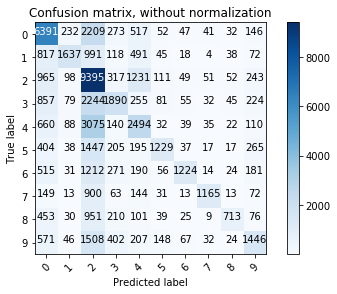

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(expected_output_test, predicted_mnb_stemmed)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = emoji.icons.unique(),
                      title='Confusion matrix, without normalization')